# Neural style transfer

([Gatys et al., 2015](https://arxiv.org/abs/1508.06576))

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import time
from PIL import Image
import numpy as np

from keras import backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


## Загрузим изображение которое будем преобразовывать

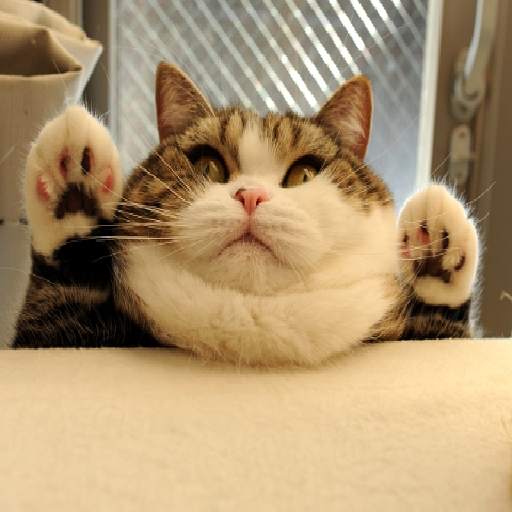

In [4]:
height = 512
width = 512

content_image_path = 'images/maru.png'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

## Загрузим изображение которое будет таргетом "стиля"

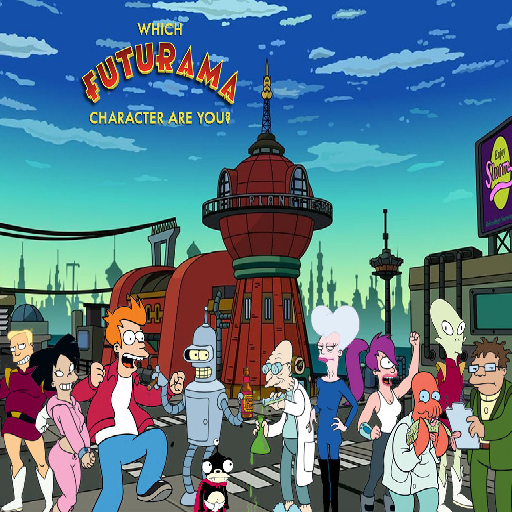

In [5]:
style_image_path = 'images/futurama.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [6]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

In [7]:
content_array = preprocess_input(content_array)
style_array = preprocess_input(style_array)

In [8]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)
combination_image = K.placeholder((1, height, width, 3))

In [9]:
input_tensor = K.concatenate([content_image, style_image, combination_image], axis=0)

----
## Загрузим VGG-16

In [10]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [11]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <t

----
## Веса: стиль vs контент + регуляризация

In [12]:
content_weight = 0.025
style_weight = 10.0
total_variation_weight = 1.0

In [13]:
loss = K.variable(0.)

### Content loss

Используем выход с слоя - `block2_conv2`


![Content feature reconstruction](images/content-feature.png "Content feature reconstruction")

In [14]:
def content_loss(content, combination):
    return K.sum(K.square(content-combination))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### The style loss

Используем матрицу Грамма


In [15]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2,0,1)))
    return K.dot(features, K.transpose(features))

In [16]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S-C))/(4* channels**2 * size**2)

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    
    style_features = layer_features[1, :, :, :]
    
    combination_features = layer_features[2, :, :, :]
    
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss

Регуляризация, чтобы изображение было однородным

In [17]:
def total_variation_loss(x):
    a = K.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = K.square(x[:,:height-1,:width-1,:]-x[:,:height-1,1:,:])
    return K.sum(K.pow(a+b,1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

----
## Достанем градиенты

In [18]:
grads = K.gradients(loss, combination_image)

In [19]:
outputs = [loss]
outputs += grads
f_outputs = K.function([combination_image], outputs)

In [20]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

-----
## Запустим оптимизацию используя метод L-BFGS из SciPy

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    
    print('Iteration # {}'.format(i))
    
    start_time = time.time()
    
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    
    print('Loss = {}'.format(min_val))
    end_time = time.time()
    print('Time spent {:.2f}s \n'.format(end_time - start_time))

Iteration # 0
Loss = 328981610496.0
Time spent 895.26s 

Iteration # 1


----
## Посмотрим что получилось

In [ ]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

In [ ]:
Image.fromarray(x)